# Import Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier

# Save best model
import joblib

# Import Data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anishdevedward/loan-approval-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Musa\.cache\kagglehub\datasets\anishdevedward\loan-approval-dataset\versions\1


In [3]:
import os

path = r"C:\Users\Musa\.cache\kagglehub\datasets\anishdevedward\loan-approval-dataset\versions\1"
os.listdir(path)

['loan_approval.csv']

In [4]:
import pandas as pd

file_path = r"C:\Users\Musa\.cache\kagglehub\datasets\anishdevedward\loan-approval-dataset\versions\1\loan_approval.csv"
df = pd.read_csv(file_path)

# Display first few rows
df.head()

,name,city,income,credit_score,loan_amount,years_employed,points,loan_approved
0,Allison Hill,East Jill,113810,389,39698,27,50.0,False
1,Brandon Hall,New Jamesside,44592,729,15446,28,55.0,False
2,Rhonda Smith,Lake Roberto,33278,584,11189,13,45.0,False
3,Gabrielle Davis,West Melanieview,127196,344,48823,29,50.0,False
4,Valerie Gray,Mariastad,66048,496,47174,4,25.0,False


# Exploratory Data Analysis

In [33]:
# 2. Basic EDA
print(df.shape)
print("---"*10)
print(df.describe())
print("---"*10)
print(df.isnull().sum())
print("---"*10)
print(df['loan_approved'].value_counts())

(2000, 7)
------------------------------
             city       income  credit_score  loan_amount  years_employed  \
count  2000.00000  2000.000000   2000.000000  2000.000000     2000.000000   
mean    945.60100     0.504816      0.498084     0.495876        0.511025   
std     542.04525     0.287612      0.291936     0.290081        0.294445   
min       0.00000     0.000000      0.000000     0.000000        0.000000   
25%     477.75000     0.260554      0.241818     0.239434        0.250000   
50%     948.50000     0.503161      0.501818     0.503083        0.525000   
75%    1411.25000     0.750947      0.754545     0.742359        0.775000   
max    1881.00000     1.000000      1.000000     1.000000        1.000000   

            points  loan_approved  
count  2000.000000     2000.00000  
mean      0.518667        0.43950  
std       0.207089        0.49645  
min       0.000000        0.00000  
25%       0.388889        0.00000  
50%       0.500000        0.00000  
75%       0.6

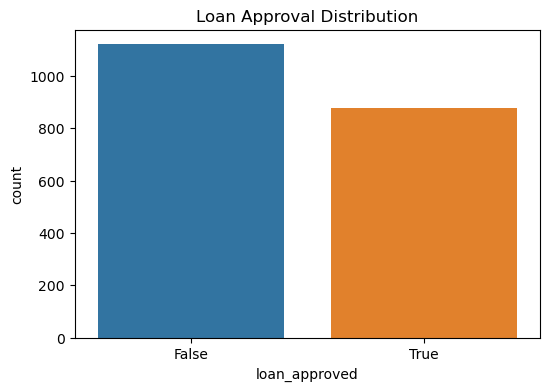

In [13]:
# 3. Visualization
plt.figure(figsize=(6,4))
sns.countplot(x='loan_approved', data=df)
plt.title('Loan Approval Distribution')
plt.show()

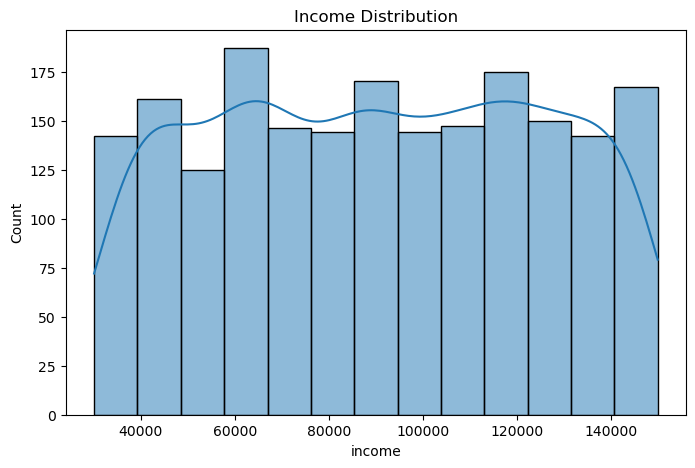

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(df['income'], kde=True)
plt.title('Income Distribution')
plt.show()

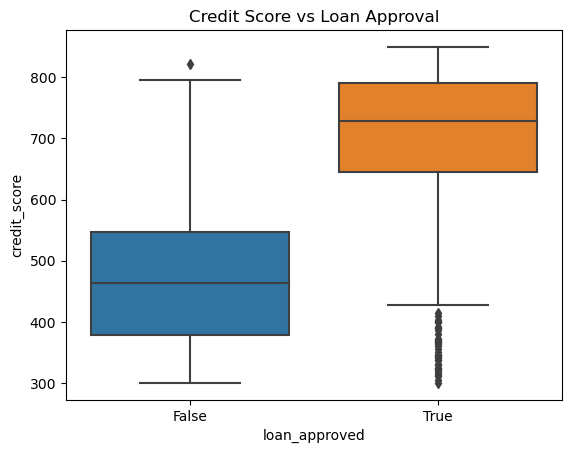

In [15]:
sns.boxplot(x='loan_approved', y='credit_score', data=df)
plt.title('Credit Score vs Loan Approval')
plt.show()

In [16]:
df.columns

Index(['name', 'city', 'income', 'credit_score', 'loan_amount',
       'years_employed', 'points', 'loan_approved'],
      dtype='object')

In [17]:
# Select numeric columns
num_cols = ['income', 'credit_score', 'loan_amount', 'years_employed', 'points']

# Function to detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

for col in num_cols:
    outliers, lb, ub = detect_outliers_iqr(df, col)
    print(f"📌 {col} → Outliers found: {len(outliers)} (Lower: {lb:.2f}, Upper: {ub:.2f})")

📌 income → Outliers found: 0 (Lower: -26909.00, Upper: 208305.00)
📌 credit_score → Outliers found: 0 (Lower: 10.00, Upper: 1138.00)
📌 loan_amount → Outliers found: 0 (Lower: -24198.88, Upper: 74328.12)
📌 years_employed → Outliers found: 0 (Lower: -21.50, Upper: 62.50)
📌 points → Outliers found: 0 (Lower: 7.50, Upper: 107.50)


In [18]:
# Detect categorical columns automatically
cat_cols = df.select_dtypes(include=['object', 'bool']).columns
print("📌 Categorical Columns:", list(cat_cols))

📌 Categorical Columns: ['name', 'city', 'loan_approved']


In [19]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Encode all categorical columns
for col in cat_cols:
    df[col] = le.fit_transform(df[col])
    print(f"✅ Encoded column: {col}")

✅ Encoded column: name
✅ Encoded column: city
✅ Encoded column: loan_approved


In [20]:
if 'name' in df.columns:
    df.drop('name', axis=1, inplace=True)

In [21]:
# 3. Feature Scaling (MinMax)
# ==============================
scaler = MinMaxScaler()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('loan_approved')
df[num_cols] = scaler.fit_transform(df[num_cols])

In [22]:
# 4. Train-Test Split
# ==============================
X = df.drop('loan_approved', axis=1)
y = df['loan_approved']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Training set:", X_train.shape)
print("✅ Test set:", X_test.shape)

✅ Training set: (1600, 6)
✅ Test set: (400, 6)


In [23]:
# 5. Define Models
# ==============================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
#     "LightGBM": LGBMClassifier(random_state=42)
}

In [24]:
# 6. Train & Evaluate Models
# ==============================
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))
    
    print(f"\n📌 Model: {name}")
    print("Accuracy:", acc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 50)


📌 Model: Logistic Regression
Accuracy: 0.975

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       224
           1       0.99      0.95      0.97       176

    accuracy                           0.97       400
   macro avg       0.98      0.97      0.97       400
weighted avg       0.98      0.97      0.97       400


Confusion Matrix:
 [[223   1]
 [  9 167]]
--------------------------------------------------

📌 Model: Decision Tree
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       224
           1       1.00      1.00      1.00       176

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


Confusion Matrix:
 [[224   0]
 [  0 176]]
--------------------------------------------------

📌 Model: Random Forest


C:\Users\Musa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Musa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Musa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Musa\anaconda3\Lib\site-packages\xgboost\training

In [25]:
# 7. Best Model Selection
# ==============================
best_model_name, best_accuracy = max(results, key=lambda x: x[1])
best_model = models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")


🏆 Best Model: Decision Tree with Accuracy: 1.0000


In [26]:
# 8. Save Best Model
# ==============================
joblib.dump(best_model, 'best_loan_model.pkl')
print("✅ Best model saved as best_loan_model.pkl")

✅ Best model saved as best_loan_model.pkl


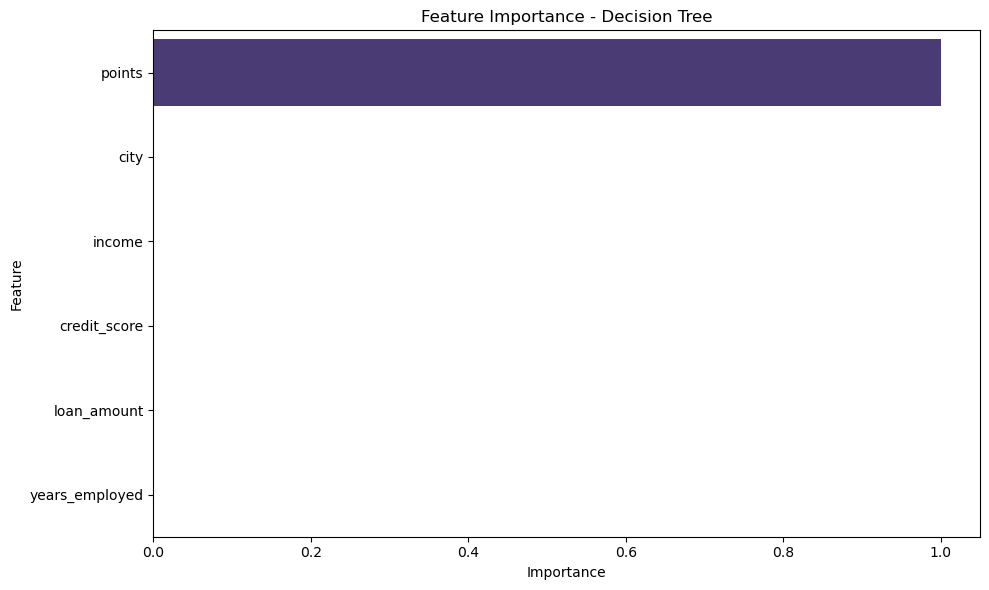

In [27]:
# 9. Feature Importance (Tree Based Models)
# ==============================
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feature_names = X.columns
    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    fi_df = fi_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Best model does not support feature importance.")

In [28]:
loaded_model = joblib.load('best_loan_model.pkl')
y_loaded_pred = loaded_model.predict(X_test)
print("\n✅ Loaded Model Accuracy:", accuracy_score(y_test, y_loaded_pred))


✅ Loaded Model Accuracy: 1.0
